# Visión Computacional Basada en Redes Neuronales Artificiales
## Grupo XX - Trabajo Práctico Especial

Integrantes del grupo:

* XXXXX
* XXXXX
* ...





### Configuración del ambiente

[Editar el número del grupo en la variable ```datasets_folder```, para que los datos con los que trabajen uds se guarden en el lugar correcto]

In [27]:
# Montamos la unidad de Google Drive
from google.colab import drive
drive.mount('/content/gdrive/')

# Imports necesarios
from os import makedirs
from torchvision import datasets, transforms
import torch

# Carpeta donde van a guardar los datos
datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/Grupo 4'  ## < EDITAR NÚMERO DE GRUPO
makedirs(datasets_folder, exist_ok=True)

# NO TOCAR EL CÓDIGO DE ACÁ ABAJO, ES PARA BAJAR DATOS NUEVOS!
new_datasets_folder = '/content/gdrive/My Drive/Colab Notebooks/Computer Vision/'
makedirs(new_datasets_folder, exist_ok=True)
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/cifar10.1_v4_data.npy*
!rm /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/cifar10.1_v4_labels.npy*
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
!wget --no-check-certificate -P /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/ https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_labels.npy
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Computer\ Vision/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
--2025-11-22 20:44:42--  https://github.com/modestyachts/CIFAR-10.1/raw/master/datasets/cifar10.1_v4_data.npy
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy [following]
--2025-11-22 20:44:43--  https://raw.githubusercontent.com/modestyachts/CIFAR-10.1/master/datasets/cifar10.1_v4_data.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6208640 (5.9M) [application/octet-stream]
Saving to: ‘/content/gdriv

### Media y std global de cada canal

1.   Elemento de la lista
2.   Elemento de la lista



In [28]:
# Cargamos CIFAR10 sin normalización (solo ToTensor) para calcular estadísticas
temp_transform = transforms.Compose([transforms.ToTensor()])
tensor_cifar10 = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=temp_transform)

# Apilamos todas las imágenes en un tensor gigante
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print(f"Shape del tensor de imágenes: {imgs.shape}")
print(f"Shape después de view: {imgs.view(3, -1).size()}")

# Calculamos la media de cada canal
mean = imgs.view(3, -1).mean(dim=1)
print(f"Media por canal (R, G, B): {mean}")

# Calculamos la desviación estándar
std = imgs.view(3, -1).std(dim=1)
print(f"Desviación estándar por canal (R, G, B): {std}")

Shape del tensor de imágenes: torch.Size([3, 32, 32, 50000])
Shape después de view: torch.Size([3, 51200000])
Media por canal (R, G, B): tensor([0.4914, 0.4822, 0.4465])
Desviación estándar por canal (R, G, B): tensor([0.2470, 0.2435, 0.2616])


### 1. Preprocesamiento Compose()


In [29]:
# Transformaciones para ENTRENAMIENTO: data augmentation + normalización + estandarización
#------------
# Por el momento, comentamos las transformaciones de data augmentation

from torchvision.transforms import Compose, ColorJitter, RandomGrayscale, RandomHorizontalFlip, RandomVerticalFlip

#list_of_training_transformations = [
 #   transforms.RandomGrayscale(p=0.2),
  #  transforms.RandomHorizontalFlip(p=0.5),
   # transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=[-45, 45], interpolation=transforms.InterpolationMode.BILINEAR),
    #transforms.ColorJitter(brightness=(0.5, 2.5), contrast=(0.75, 1.75), saturation=(0.5, 1.5)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=mean, std=std)
#]

#RandomVerticalFlip(p=0.5) En CIFAR-10, un auto dado vuelta verticalmente deja de tener sentido.
#RandomRotation(degrees=[-45, 45]) En CIFAR-10, rotaciones mayores a 15° rompen la semántica de casi todas las clases. un automóvil girado 45° parece deformado
#ColorJitter(brightness=(0.5, 2.5), contrast=(0.75, 1.75), saturation=(0.5, 1.5)) Demasiado fuerte para CIFAR-10.puede generar imágenes totalmente irreconocibles

list_of_training_transformations = [
    transforms.RandomCrop(32, padding=4), # Hace un recorte aleatorio de 32x32 agregando un padding previo de 4 píxeles.Esto simula pequeños desplazamientos y zoom in/out, aumentando la robustez del modelo.
    transforms.RandomHorizontalFlip(), # Invierte horizontalmente la imagen con probabilidad 0.5. Es la transformación más efectiva en CIFAR-10 porque muchos objetos son simétricos en este eje.
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
]


# Transformaciones para TEST/VALIDACIÓN: solo normalización + estandarización
list_of_test_transformations = [
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
]

# Generamos las transformaciones compuestas
training_transformations = transforms.Compose(list_of_training_transformations)
test_transformations = transforms.Compose(list_of_test_transformations)

# Descargamos/cargamos los datasets finales con todas las transformaciones
cifar10_training = datasets.CIFAR10(datasets_folder, train=True, download=True, transform=training_transformations)
cifar10_validation = datasets.CIFAR10(datasets_folder, train=False, download=True, transform=test_transformations)

print(f"Dataset de entrenamiento: {len(cifar10_training)} imágenes")
print(f"Dataset de validación: {len(cifar10_validation)} imágenes")

Dataset de entrenamiento: 50000 imágenes
Dataset de validación: 10000 imágenes


In [30]:
# y le pedimos a cifar10 el elemento 99.
data_sample = cifar10_training[99]
print(data_sample)

(tensor([[[-1.0526, -1.0685, -1.0685,  ..., -1.9892, -1.9892, -1.9892],
         [-1.0526, -1.0526, -1.1796,  ..., -1.9892, -1.9892, -1.9892],
         [-1.1479, -1.2590, -1.0685,  ..., -1.9892, -1.9892, -1.9892],
         ...,
         [-0.7827, -1.3701, -1.3701,  ..., -1.9892, -1.9892, -1.9892],
         [-1.7987, -1.7352, -1.5288,  ..., -1.9892, -1.9892, -1.9892],
         [-0.2747, -0.3065, -0.8145,  ..., -1.9892, -1.9892, -1.9892]],

        [[-1.0300, -1.0622, -1.0300,  ..., -1.9802, -1.9802, -1.9802],
         [-1.0139, -1.0783, -1.2072,  ..., -1.9802, -1.9802, -1.9802],
         [-1.0783, -1.2072, -1.0139,  ..., -1.9802, -1.9802, -1.9802],
         ...,
         [-1.7709, -1.8192, -1.4326,  ..., -1.9802, -1.9802, -1.9802],
         [-1.7386, -1.7709, -1.6581,  ..., -1.9802, -1.9802, -1.9802],
         [-0.6757, -0.7240, -1.0944,  ..., -1.9802, -1.9802, -1.9802]],

        [[-1.3772, -1.3172, -1.2573,  ..., -1.7070, -1.7070, -1.7070],
         [-1.2723, -1.2273, -1.3322,  ..., -

In [31]:
#Verificamos que es un tensor y label
img_t, label = cifar10_training[99]
print(type(img_t))
print(type(label))

<class 'torch.Tensor'>
<class 'int'>


### 2. Arquitectura de la Red Convolucional

In [32]:
import torch.nn as nn
import torch.nn.functional as F

class G4_CIFAR10_CNN(nn.Module): ## AirplanesAndBirdsCNN
  '''
  Una primera red neuronal convolucional
  '''

  def __init__(self):
    '''
    Constructor de la clase
    '''
    super().__init__()

    # ----- Bloque 1 -----
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False)
    # a la capa batch norm le indicamos el número de features a normalizar
    self.batch_norm_conv1 = nn.BatchNorm2d(num_features=32)


    # a la capa convolucional le tenemos que sacar el bias porque está de gusto
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
    # a la capa batch norm le indicamos el número de features a normalizar
    self.batch_norm_conv2 = nn.BatchNorm2d(num_features=64)

    # Primer MaxPool después de conv2

    # ----- Bloque 2 -----
    # capa convolucional 3
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv3 = nn.BatchNorm2d(num_features=128)

    # NUEVA CAPA CONVOLUCIONAL (conv4)
    self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
    self.batch_norm_conv4 = nn.BatchNorm2d(128)

    # Segundo MaxPool después de conv4

    # Tamaño después de dos poolings:
    # 32x32 → 16x16 → 8x8
    # y 128 filtros

    # con eso alimentamos la capa fully connected
    self.fc1 = nn.Linear(8 * 8 * 128, 256,bias=False)
    # y como la salida es un vector, tenemos que usar batch normalization 1d
    self.batch_norm_fc1 = nn.BatchNorm1d(num_features=256)

    # Dropout con probabilidad 0.3
    self.dropout = nn.Dropout(p=0.3)

    # y de esas 256 features generaremos 10 scores
    self.fc2 = nn.Linear(256, 10)
    # que pasaremos por la capa softmax para obtener probabilidades
    self.final_activation = nn.Softmax(dim=1)

  def forward(self, x):
    '''
    Método que implementa el forward pass
    '''
    # la capa de batch normalization se aplica justo después de la convolución
    # y antes de la activation function
    # ----- Bloque 1 -----
    out = F.relu(self.batch_norm_conv1(self.conv1(x)))
    out = F.relu(self.batch_norm_conv2(self.conv2(out)))
    out = F.max_pool2d(out, 2)   # 32x32 → 16x16

    # ----- Bloque 2 -----
    out = F.relu(self.batch_norm_conv3(self.conv3(out)))

   # Nueva capa
    out = F.relu(self.batch_norm_conv4(self.conv4(out)))
    out = F.max_pool2d(out, 2)   # 16x16 → 8x8


    out = out.view(-1, 8 * 8 * 128)

    # capa fully connected
    out = torch.relu(self.batch_norm_fc1(self.fc1(out)))

    # dropout solo en entrenamiento (PyTorch lo maneja solo)
    out = self.dropout(out)

    # y después por la última capa
    out = self.fc2(out)
    return out


  def predict(self, inputs):
    '''
    Método que usaremos de aquí en más cuando queremos predecir resultados
    '''
    # devolvemos el resultado de llamar al modelo y aplicarle la función de activación
    return self.final_activation(self.__call__(inputs))

## Early Stopping Class

In [33]:
# Clase Early Stopping (definir antes del training loop)
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        """
        Args:
            patience (int): Cuántas epochs esperar después de la última mejora
            min_delta (float): Cambio mínimo para considerar una mejora
            restore_best_weights (bool): Si restaurar los mejores pesos al final
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on epoch"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        self.status = f"Patience: {self.counter}/{self.patience}"
        return False

### 3. Training Loop



In [34]:
# Función de training loop modificada
def G4_training_loop(n_epochs, optimizer, model, loss_fn, train_loader, validation_loader, device, is_fully_connected=False, early_stopping_patience=None):

    training_loss_per_epoch = []
    validation_loss_per_epoch = []
    training_accuracy_per_epoch = []
    validation_accuracy_per_epoch = []

    # Inicializar early stopping si se especifica patience
    early_stopping = EarlyStopping(patience=early_stopping_patience, min_delta=0.001, restore_best_weights=True) if early_stopping_patience else None

    for epoch in range(1, n_epochs + 1):

        # ==========================
        #        TRAINING
        # ==========================

        loss_train = 0.0
        total = 0
        correct = 0
        model.train()

        for imgs, labels in train_loader:

            if is_fully_connected:
                batch_size = imgs.shape[0]
                imgs = imgs.view(batch_size, -1)

            imgs = imgs.to(device)

            # ----- FIX CRÍTICO -----
            if not torch.is_tensor(labels):
                labels = torch.tensor(labels)
            labels = labels.view(-1)      # <--- evita batch_size = 0
            labels = labels.to(device)
            # ------------------------

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # accuracy (sin softmax)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += int((predicted == labels).sum())

        training_loss_per_epoch.append(loss_train / len(train_loader))
        training_accuracy_per_epoch.append(correct / total)

        # ==========================
        #       VALIDATION
        # ==========================

        loss_val = 0.0
        total = 0
        correct = 0
        model.eval()

        with torch.no_grad():
            for imgs, labels in validation_loader:

                if is_fully_connected:
                    batch_size = imgs.shape[0]
                    imgs = imgs.view(batch_size, -1)

                imgs = imgs.to(device)

                # ----- FIX CRÍTICO -----
                if not torch.is_tensor(labels):
                    labels = torch.tensor(labels)
                labels = labels.view(-1)
                labels = labels.to(device)
                # ------------------------

                outputs = model(imgs)

                loss = loss_fn(outputs, labels)
                loss_val += loss.item()

                _, predicted = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += int((predicted == labels).sum())

        validation_loss_per_epoch.append(loss_val / len(validation_loader))
        validation_accuracy_per_epoch.append(correct / total)

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}:")
            print(f" ---> Loss: Training {training_loss_per_epoch[-1]:.4f} - Validation {validation_loss_per_epoch[-1]:.4f}")
            print(f" ---> Accuracy: Training {training_accuracy_per_epoch[-1]:.4f} - Validation {validation_accuracy_per_epoch[-1]:.4f}")
            if early_stopping:
                print(f" ---> {early_stopping.status}")

        # Verificar early stopping
        if early_stopping:
            if early_stopping(model, validation_loss_per_epoch[-1]):
                print(f"\n⚠️ Early Stopping activado en epoch {epoch}")
                print(f"Mejor validation loss: {early_stopping.best_loss:.4f}")
                break

    return model, training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch

## Plot de loss y accuracy por época

In [35]:
import matplotlib.pyplot as plt

def plot_training_statistics(training_loss_per_epoch, validation_loss_per_epoch, training_accuracy_per_epoch, validation_accuracy_per_epoch):
  '''
  Plotea las estadísticas sobre datos de entrenamiento y validación
  (loss function y valores de accuracy)
  '''

  # creamos plots para la loss y el accuracy
  fig, axes = plt.subplots(1, 2)
  # graficamos la evolución de la loss de entrenamiento y la de validación
  axes[0].plot(training_loss_per_epoch, color='blue')
  axes[0].plot(validation_loss_per_epoch, color='red')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Cross entropy loss')
  axes[0].grid(True)
  axes[0].legend(['Training set', 'Validation set'])
  axes[0].set_title('Loss function')
  # graficamos la evolución del accuracy en los datos de entrenamiento y validación
  axes[1].plot(training_accuracy_per_epoch, color='blue')
  axes[1].plot(validation_accuracy_per_epoch, color='red')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].grid(True)
  axes[1].legend(['Training set', 'Validation set'])
  axes[1].set_title('Accuracy')
  axes[1].set_ylim([0, 1.0])
  fig.tight_layout(pad=3.0)

## Ejecución del entrenamiento

Epoch 1:
 ---> Loss: Training 1.2465 - Validation 1.0295
 ---> Accuracy: Training 0.5514 - Validation 0.6393
 ---> 
Epoch 10:
 ---> Loss: Training 0.4555 - Validation 0.4410
 ---> Accuracy: Training 0.8412 - Validation 0.8455
 ---> Patience: 0/15
Epoch 20:
 ---> Loss: Training 0.3163 - Validation 0.4034
 ---> Accuracy: Training 0.8900 - Validation 0.8667
 ---> Patience: 4/15
Epoch 30:
 ---> Loss: Training 0.2467 - Validation 0.3585
 ---> Accuracy: Training 0.9142 - Validation 0.8858
 ---> Patience: 3/15
Epoch 40:
 ---> Loss: Training 0.2053 - Validation 0.3812
 ---> Accuracy: Training 0.9267 - Validation 0.8842
 ---> Patience: 1/15
Epoch 50:
 ---> Loss: Training 0.1820 - Validation 0.3854
 ---> Accuracy: Training 0.9352 - Validation 0.8887
 ---> Patience: 11/15

⚠️ Early Stopping activado en epoch 53
Mejor validation loss: 0.3427


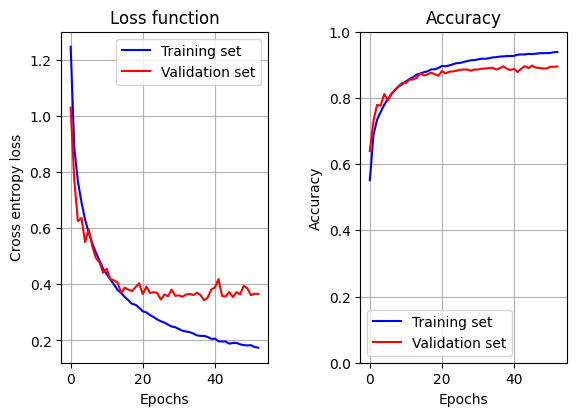

In [36]:
import torch.optim as optim
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import DataLoader # Import DataLoader

import torchvision
import torchvision.transforms as transforms
import copy

# elegimos usar gpu
use_gpu = True
if use_gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

# creamos una instancia del modelo
basic_cnn_model = G4_CIFAR10_CNN()
# creamos la loss function
loss_fn = nn.CrossEntropyLoss()
# movemos todo lo que haga falta al dispositivo que hayamos elegido
basic_cnn_model = basic_cnn_model.to(device)
loss_fn = loss_fn.to(device)
# inicializamos un valor de learning rate
learning_rate = 0.001
# creamos una instancia de un optimizador (por ejemplo, SGD),
# pasándole los parámetros de nuestro modelo y la learning rate que queremos usar
optimizer = optim.AdamW(basic_cnn_model.parameters(), lr=learning_rate, weight_decay=0.01)
# determinamos el número de épocas por el que queremos entrenar
n_epochs = 100

# Define batch size
batch_size = 64 # You can adjust this value

# Create DataLoaders for batching
train_loader = DataLoader(cifar10_training, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(cifar10_validation, batch_size=batch_size, shuffle=False)

# Con early stopping (patience=10)
model, train_loss, val_loss, train_acc, val_acc = G4_training_loop(
    n_epochs=100,
    optimizer=optimizer,
    model=basic_cnn_model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    validation_loader=validation_loader,
    device=device,
    is_fully_connected=False,
    early_stopping_patience=15  # <--- Nuevo parámetro opcional
)

# ploteamos los resultados
plot_training_statistics(train_loss, val_loss, train_acc, val_acc)

In [37]:
torch.save(basic_cnn_model.state_dict(), 'best_model_early_stopping_AdamW.pth') ## Guardar mejor modelo

In [38]:
torch.save({
    'epoch': n_epochs,
    'model_state': basic_cnn_model.state_dict(),
    'optimizer_state': optimizer.state_dict(),
}, 'best_model_early_stopping_AdamW_checkpoint.pth')

In [39]:
print(cifar10_training)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/gdrive/My Drive/Colab Notebooks/Computer Vision/Grupo 4
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=tensor([0.4914, 0.4822, 0.4465]), std=tensor([0.2470, 0.2435, 0.2616]))
           )


In [40]:
# Encontrar en qué época se obtuvo el mejor validation loss
best_epoch = val_loss.index(min(val_loss)) + 1
best_val_loss = val_loss[best_epoch - 1]
best_val_acc = val_acc[best_epoch - 1]

print(f"\n📊 RESULTADOS DEL MEJOR MODELO:")
print(f"   Época: {best_epoch}")
print(f"   Validation Loss: {best_val_loss:.4f}")
print(f"   Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"   Training Loss: {train_loss[best_epoch - 1]:.4f}")
print(f"   Training Accuracy: {train_acc[best_epoch - 1]:.4f} ({train_acc[best_epoch - 1]*100:.2f}%)")


📊 RESULTADOS DEL MEJOR MODELO:
   Época: 38
   Validation Loss: 0.3427
   Validation Accuracy: 0.8955 (89.55%)
   Training Loss: 0.2161
   Training Accuracy: 0.9252 (92.52%)


### 4. Evaluación sobre nuevos datos

A continuación les dejamos código que les permite abrir una serie de imágenes nuevas sobre las que podrían validar el algoritmo que implementaron.

Tienen que desarrollar las rutinas necesarias para:
* Convertir estas imágenes a tensores con los tamaños adecuados para poder procesarlos.
* Normalizarlos (utilizando las estadísticas que calculamos sobre los datos de entrenamiento).
* Iterar imagen por imagen y obtener su etiqueta utilizando la red neuronal convolucional entrenada.
* Calcular una o varias métricas de evaluación.
* Mostrar algunos ejemplos de resultados correctos o errados.

In [ ]:
#import numpy as np
#from os import path
#import matplotlib.pyplot as plt
#
## accedemos a los datos
#images = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_data.npy'))
#labels = np.load(path.join(new_datasets_folder, 'cifar10.1_v4_labels.npy'))
## los ponemos con los ejes en el lugar que queremos
#images = np.transpose(images, axes=(0,3,1,2))
## imprimimos los tamaños
#print(images.shape)
#print(labels.shape)
#
## ACA ABAJO TIENEN QUE IMPLEMENTAR LA SOLUCIÓN